In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

## Problem: Partion Problem



As an initial problem we study the number partitioning problem. Given a set $S$ of $N$ positive numbers 
$S = \{ n_{0}, \ldots , n_{N-1}\}$, is there a partition of $S$ into $P$ disjoint subsets $\{ R_0, \ldots , R_{P-1} \}$, such that the sum of values in 
each set is the same. I.e., can a set of $N$ assets with values $n_0, \ldots , n_{N-1}$ fairly be distributed between $P$ parties?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{p=0}^{P-1}  \left( \sum_{i=0}^{N-1} n_{i} x_{i, p} - \frac{1}{P} \sum_{i=0}^{N-1} n_{i} \right)^2 + M \sum_{i=0}^{N-1}  \left( 1- \sum_{p=0}^{P-1} x_{i, p} \right)^2 \, ,
\end{align}

and the decision variable $x_{i, p} \in \{0,1\}$ is defined as

\begin{align}
	x_{i, p} = 
    \begin{cases}
	1 & \text{if number } n_i \text{ of set } S \text{ is in set } R_p \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

- $P=4$: Number of subsets.
- $N$: Number of values in set $S$.
- ${\rm{bits}} = N \cdot P$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

In [2]:
### nice plots

import matplotlib as matp

matp.rcParams['mathtext.fontset'] = 'stix'
matp.rcParams['font.family'] = 'STIXGeneral'

## Read data for analysis

In [3]:
class Datas():
    def __init__(self, bits_idx_list, vseed_list, n_temp_scalers, M_strats, n_eta_runs, n_samples_SA = 128):
        Ps = np.arange(2,15)
        Ns = 8*Ps
        self.Ns = Ns[bits_idx_list]
        self.Ps = Ps[bits_idx_list]
        self.bits = Ns[bits_idx_list] * Ps[bits_idx_list]
        self.M_strategies = M_strats # index: 0->"feasibility", 1->"optimality"
        self.temperature_scalers = [1, 10, 100]
        self.SA_samples = 128

        self.M_star = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.M_L1 = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_required = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_guaranteed = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.eta_effective = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, len(M_strats), n_eta_runs))
        self.temperature = np.ndarray((len(bits_idx_list), len(vseed_list), n_temp_scalers, 2)) # last index: 0->initial, 1->final
        self.E_f = np.ndarray((len(bits_idx_list), len(vseed_list)))

In [5]:
## Dataset 

colors = sns.color_palette("Paired", 12)

Ps = np.arange(2,15)
Ns = 8*Ps
n_vseeds = 4
runs = 128
vseeds = np.array([42, 43, 44, 45])


In [6]:
N_idxs = np.arange(7)
n_temp_scalers = 3
M_strategies = ["feasibility", "optimality"]
n_eta_runs = 3
data = Datas(N_idxs, vseeds, n_temp_scalers, M_strategies, n_eta_runs)

directory = "../data/SA_NPP/"

for N_idx in N_idxs: # if N_idxs start from 0. Else, write "for N_idx_idx, N_idx in enumerate(N_idxs):"
    filename = directory + f"results-N={Ns[N_idx]}_P={Ps[N_idx]}.txt"
    file = open(filename, "rb")
    D = pickle.load(file)
    file.close()

    assert len(D.keys()) == len(vseeds)
    for seed_idx, seed in enumerate(D):
        data.E_f[N_idx, seed_idx] = D[seed]["E_f"]
        
        # print(N_idx, seed)
        # print(D[seed].keys())
        assert len(D[seed].keys()) - 1 == n_temp_scalers
        for temp_idx, temp_scaler in enumerate(list(D[seed])[1:]):
            data.temperature[N_idx, seed_idx, temp_idx, 0] = D[seed][temp_scaler]["temp_initial"]
            data.temperature[N_idx, seed_idx, temp_idx, 1] = D[seed][temp_scaler]["temp_final"]

            assert len(D[seed][temp_scaler].keys()) - 2 == len(M_strategies)
            for M_strat_idx, M_strat in enumerate(list(D[seed][temp_scaler])[2:]):
                assert len(D[seed][temp_scaler][M_strat].keys()) == n_eta_runs
                for eta_run_idx, eta_run in enumerate(D[seed][temp_scaler][M_strat]):
                    data.M_star[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_run]["M_star"]
                    data.M_L1[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_run]["M_L1"]
                    data.eta_required[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_run]["eta_required"]
                    data.eta_guaranteed[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_run]["eta_guaranteed"]
                    data.eta_effective[N_idx, seed_idx, temp_idx, M_strat_idx, eta_run_idx] = D[seed][temp_scaler][M_strat][eta_run]["eta_effective"]

## $\eta_{eff} / \eta_{guar} (\beta_f scaler)$ for different $\eta_{req}$ and feas/opt $M$ strategies

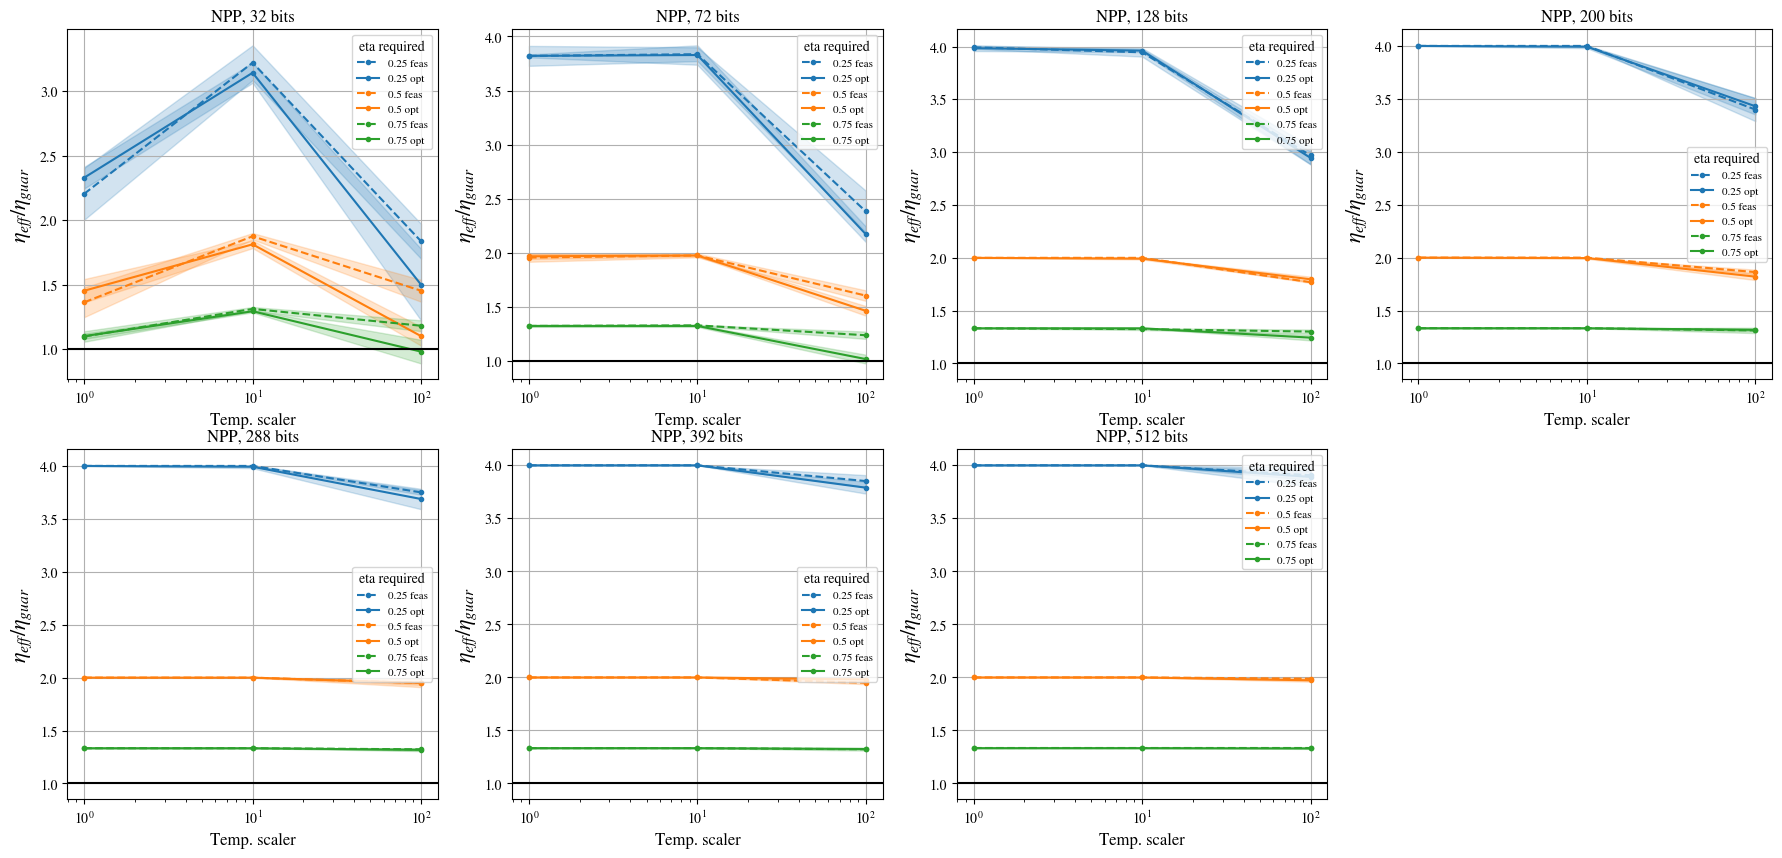

In [7]:
fig = plt.figure(figsize=(22,10))
for N_idx in N_idxs:
    ratios = np.mean( data.eta_effective[N_idx, ...] / data.eta_guaranteed[N_idx, ...] , axis = 0)
    ratios_std = np.std( data.eta_effective[N_idx, ...] / data.eta_guaranteed[N_idx, ...] , axis = 0)
    
    ax = fig.add_subplot(2,4,N_idx+1)
    ax.set_xlabel('Temp. scaler', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot([1, 10, 100], ratios[:, 0, eta_run_idx], "--", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " feas")
        ax.plot([1, 10, 100], ratios[:, 1, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " opt")
        ax.fill_between([1, 10, 100], ratios[:, 0, eta_run_idx] - ratios_std[:, 0, eta_run_idx], ratios[:, 0, eta_run_idx] + ratios_std[:, 0, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
        ax.fill_between([1, 10, 100], ratios[:, 1, eta_run_idx] - ratios_std[:, 1, eta_run_idx], ratios[:, 1, eta_run_idx] + ratios_std[:, 1, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
    ax.set_xscale("log")
    ax.set_title(f"NPP, {Ns[N_idx] * Ps[N_idx]} bits")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

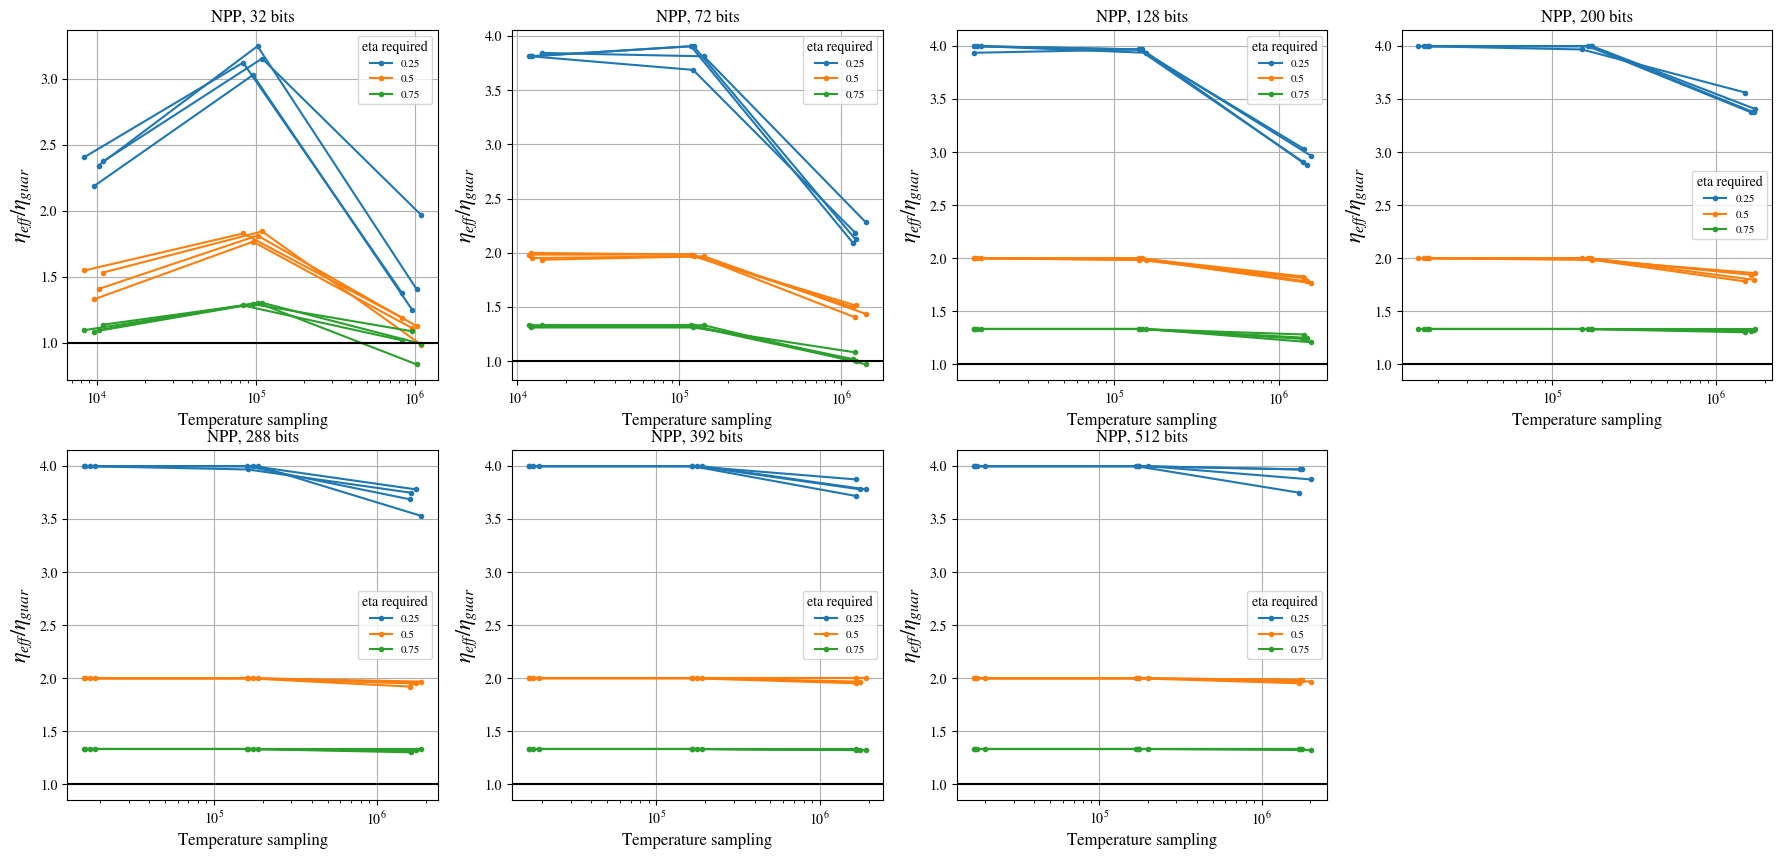

In [9]:
Mstrat = 1

fig = plt.figure(figsize=(22,10))
for N_idx in N_idxs:
    ratios = data.eta_effective[N_idx, :, :, Mstrat, :] / data.eta_guaranteed[N_idx, :, :, Mstrat, :] # [seed_idx, temp_idx, eta_run_idx]
    ax = fig.add_subplot(2,4,N_idx+1)
    ax.set_xlabel('Temperature sampling', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        for seed_idx in np.arange(n_vseeds):
            if seed_idx == 0:
                ax.plot(data.temperature[N_idx, seed_idx, :, 1], ratios[seed_idx, :, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
            else:
                ax.plot(data.temperature[N_idx, seed_idx, :, 1], ratios[seed_idx, :, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}")
    ax.set_xscale("log")
    ax.set_title(f"NPP, {Ns[N_idx] * Ps[N_idx]} bits")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

## $\eta_{eff} / \eta_{guar} (n_{bits})$

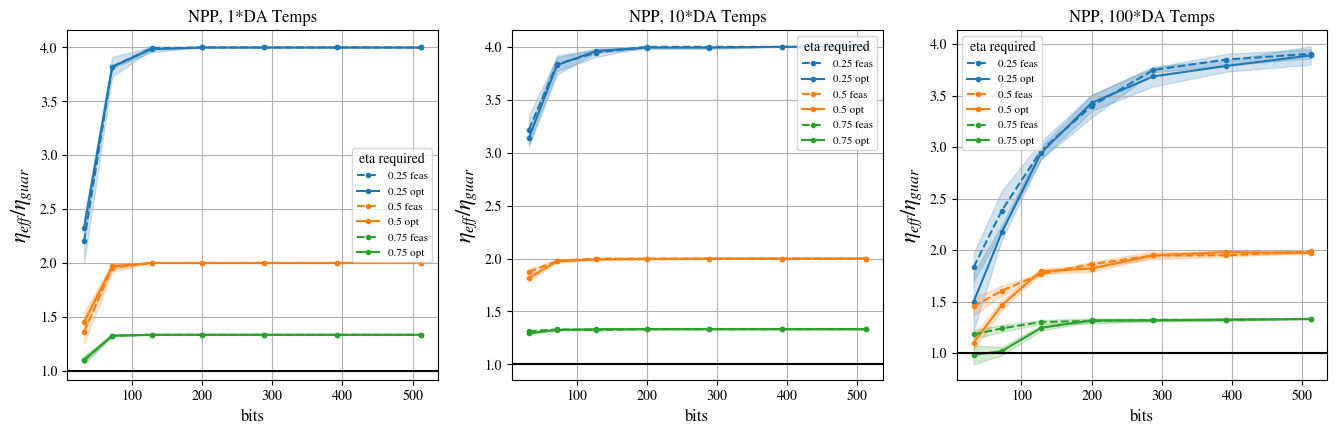

In [10]:
fig = plt.figure(figsize=(22,10))
for temp_idx in range(n_temp_scalers):
    ratios = np.mean( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    ratios_std = np.std( data.eta_effective[:, :, temp_idx, ...] / data.eta_guaranteed[:, :, temp_idx, ...] , axis = 1)
    
    ax = fig.add_subplot(2,4,temp_idx+1)
    ax.set_xlabel('bits', fontsize = 12)
    ax.set_ylabel(r'$\eta_{eff} / \eta_{guar}$', fontsize = 16)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits, ratios[:, 0, eta_run_idx], "--", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " feas")
        ax.plot(data.bits, ratios[:, 1, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]) + " opt")
        ax.fill_between(data.bits, ratios[:, 0, eta_run_idx] - ratios_std[:, 0, eta_run_idx], ratios[:, 0, eta_run_idx] + ratios_std[:, 0, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
        ax.fill_between(data.bits, ratios[:, 1, eta_run_idx] - ratios_std[:, 1, eta_run_idx], ratios[:, 1, eta_run_idx] + ratios_std[:, 1, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
    #ax.set_xscale("log")
    ax.set_title(f"NPP, {data.temperature_scalers[temp_idx]}*DA Temps")
    ax.axhline(1, color = "k")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

## $log( M_{\ell_1} / M^*)(n_{bits})$ for different temperatures

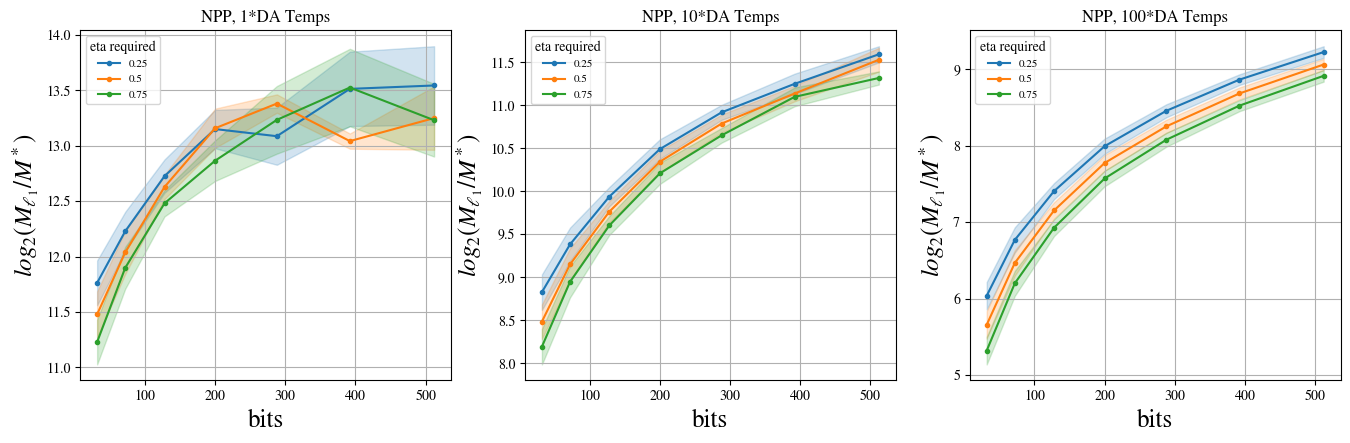

For N_idx = 2, the values for 4 different instances at eta_req = 0.25, temp_scal=1 are: [12.7633482  12.93596622 12.51703648 12.68642074]
For N_idx = 3, the values for 4 different instances at eta_req = 0.25, temp_scal=1 are: [13.31536602 12.89452199 13.08863735 13.30282835]
For N_idx = 4, the values for 4 different instances at eta_req = 0.25, temp_scal=1 are: [13.03099994 13.22463857 12.6973657  13.3913589 ]


In [11]:
Mstrat = 0

fig = plt.figure(figsize=(22,10))
for temp_idx in range(n_temp_scalers):
    logs = np.mean(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...])  , axis = 1)
    logs_std = np.std(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...]) , axis = 1)
    
    ax = fig.add_subplot(2,4,temp_idx+1)
    ax.set_xlabel('bits', fontsize = 18)
    ax.set_ylabel(r'$log_2( M_{\ell_1} / M^*)$', fontsize = 18)

    for eta_run_idx in np.arange(n_eta_runs):
        ax.plot(data.bits, logs[:, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
        ax.fill_between(data.bits, logs[:, eta_run_idx] - logs_std[:, eta_run_idx], logs[:, eta_run_idx] + logs_std[:, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
    #ax.set_xscale("log")
    ax.set_title(f"NPP, {data.temperature_scalers[temp_idx]}*DA Temps")
    ax.legend(title = "eta required", fontsize = 8, loc='best')
    ax.grid()
plt.show()

Mstrat = 0
temp_idx = 0
eta_idx = 0
for N_idx in [2,3,4]:
    print(f"For N_idx = {N_idx}, the values for 4 different instances at eta_req = 0.25, temp_scal=1 are:", np.log2(data.M_L1[N_idx, :, temp_idx, Mstrat, eta_idx] / data.M_star[N_idx, :, temp_idx, Mstrat, eta_idx])  )

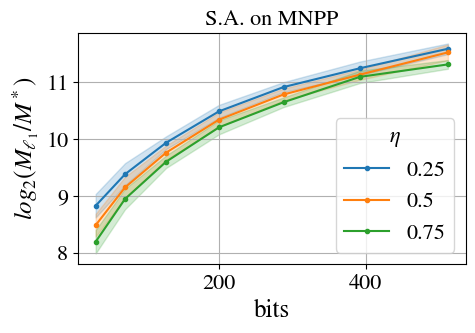

In [14]:
Mstrat = 0
temp_idx = 1

logs = np.mean(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...])  , axis = 1)
logs_std = np.std(  np.log2(data.M_L1[:, :, temp_idx, Mstrat, ...] / data.M_star[:, :, temp_idx, Mstrat, ...]) , axis = 1)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.set_xlabel('bits', fontsize = 18)
ax.set_ylabel(r'$log_2( M_{\ell_1} / M^*)$', fontsize = 18)

for eta_run_idx in np.arange(n_eta_runs):
    ax.plot(data.bits, logs[:, eta_run_idx], "-", marker = ".", color = f"C{eta_run_idx}", label=str(data.eta_required[N_idx, 0, 0, 0, eta_run_idx]))
    ax.fill_between(data.bits, logs[:, eta_run_idx] - logs_std[:, eta_run_idx], logs[:, eta_run_idx] + logs_std[:, eta_run_idx], color = f"C{eta_run_idx}", alpha=.2)
#ax.set_xscale("log")
ax.set_title(f"S.A. on MNPP", fontsize = 16)
ax.legend(title = r"$\eta$", fontsize = 16, loc='best', title_fontsize = 16)
ax.grid()
ax.tick_params(axis='both', labelsize=16)
plt.show()

# fig.savefig("plots/scale_niters_SA", bbox_inches='tight')
